# Customer Lifetime Value

This notebook will illustrate adding additional model types to the prediction of Customer Churn. Then, the data from the model will be used to identify the most attractive customers to use for potential incentive offers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
%matplotlib inline
%config InlineBackend.figure_formats = ["retina"]
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier # conda install -c conda-forge xgboost
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC, SVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from plotnine import * # conda install -c conda-forge plotnine
from plotnine.data import *
import mizani # conda install -c conda-forge mizani

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import set_config
set_config(display="diagram")
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
from plot_metric.functions import BinaryClassification # pip install plot-metric
import scikitplot as skplt # conda install -c conda-forge scikit-plot
from mlxtend.plotting import plot_confusion_matrix # pip mlxtend

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm

In [3]:
mydata = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
orig_df = mydata

In [4]:
mydata.shape

(7043, 21)

In [5]:
mydata.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
mydata.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
# https://drawingfromdata.com/pandas/dtypes/finding-invalid-values-in-numerical-columns.html
mydata['TotalCharges'] = mydata['TotalCharges'].replace(' ', np.nan).astype(float)
mydata.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [9]:
# Senior Citizen should be a boolean vice a numeric
mydata['SeniorCitizen'] = mydata['SeniorCitizen'].apply(lambda x: "Senior" if x == 1 else "NotSC")
mydata.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


In [10]:
# the target variable needs to be encoded
mydata['Churn'] = mydata['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
mydata.describe()

,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7032.000000,7043.000000
mean,32.371149,64.761692,2283.300441,0.265370
std,24.559481,30.090047,2266.771362,0.441561
min,0.000000,18.250000,18.800000,0.000000
25%,9.000000,35.500000,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,0.000000
75%,55.000000,89.850000,3794.737500,1.000000
max,72.000000,118.750000,8684.800000,1.000000


In [11]:
mydata = mydata.dropna()
mydata.shape

(7032, 21)

In [12]:
backup_df = mydata

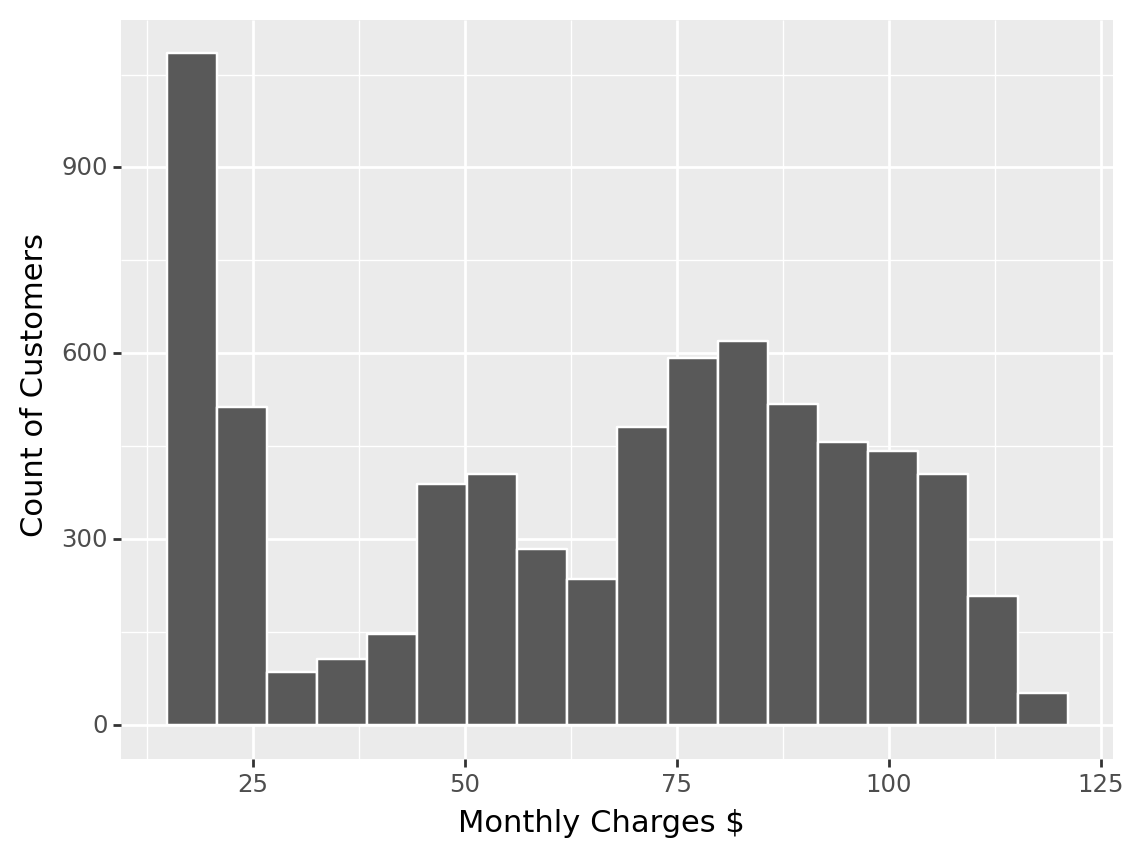

<ggplot: (332716961)>

In [13]:
# https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_histogram.html
(
    ggplot(mydata, aes(x='MonthlyCharges'))
    + geom_histogram(color='white')
    + labs(y="Count of Customers", x = "Monthly Charges $")
)

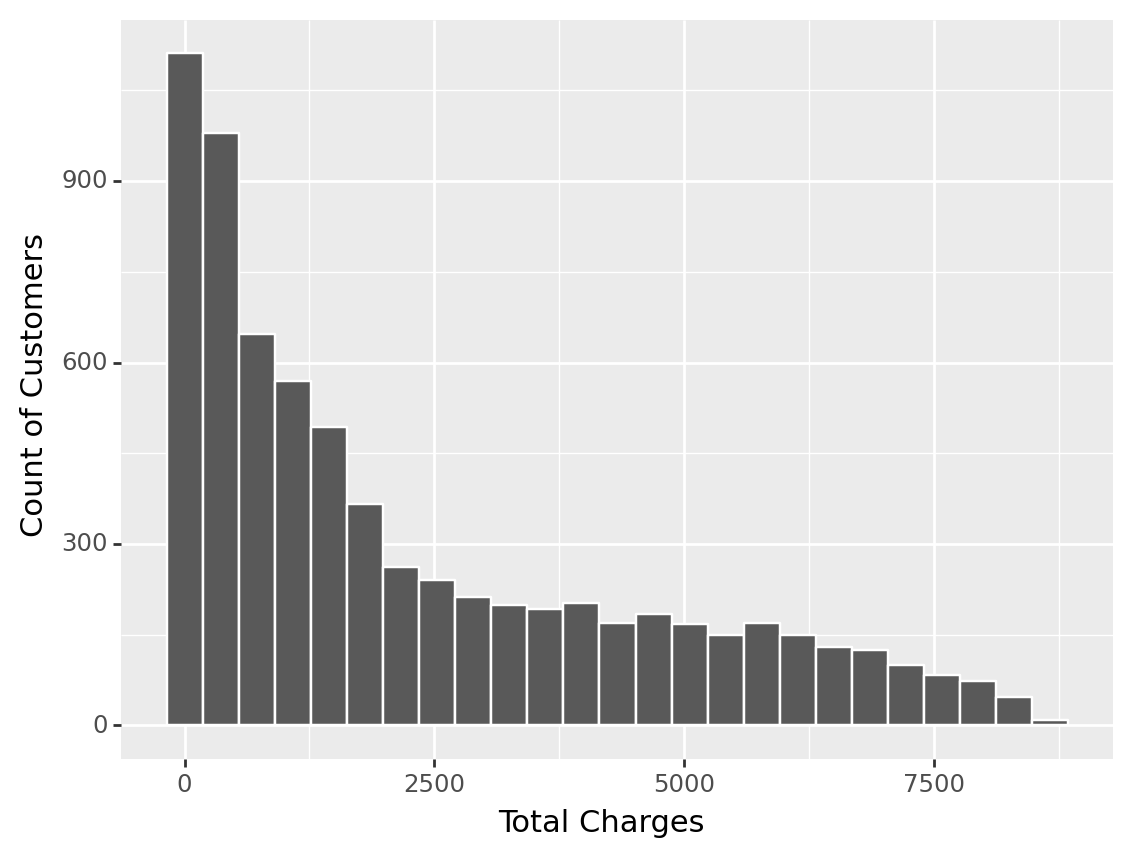

<ggplot: (331919037)>

In [14]:
(
    ggplot(mydata, aes(x='TotalCharges'))
    + geom_histogram(color='white')
    + labs(y="Count of Customers", x = "Total Charges")
)

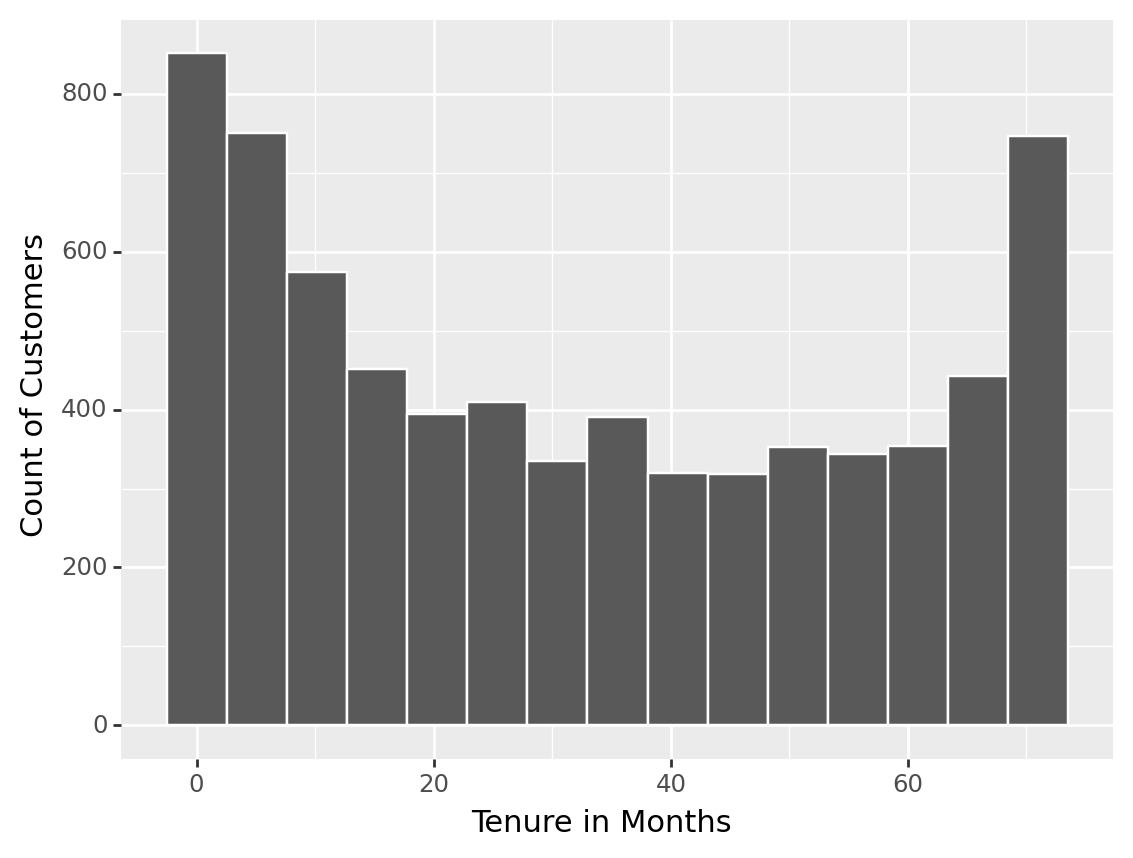

<ggplot: (333018341)>

In [15]:
(
    ggplot(mydata, aes(x='tenure'))
    + geom_histogram(color='white')
    + labs(y="Count of Customers", x = "Tenure in Months")
)

In [16]:
mydata['leave'] = mydata['Churn'].apply(lambda x: "Yes" if x == 1 else "No")

<function matplotlib.pyplot.show(close=None, block=None)>

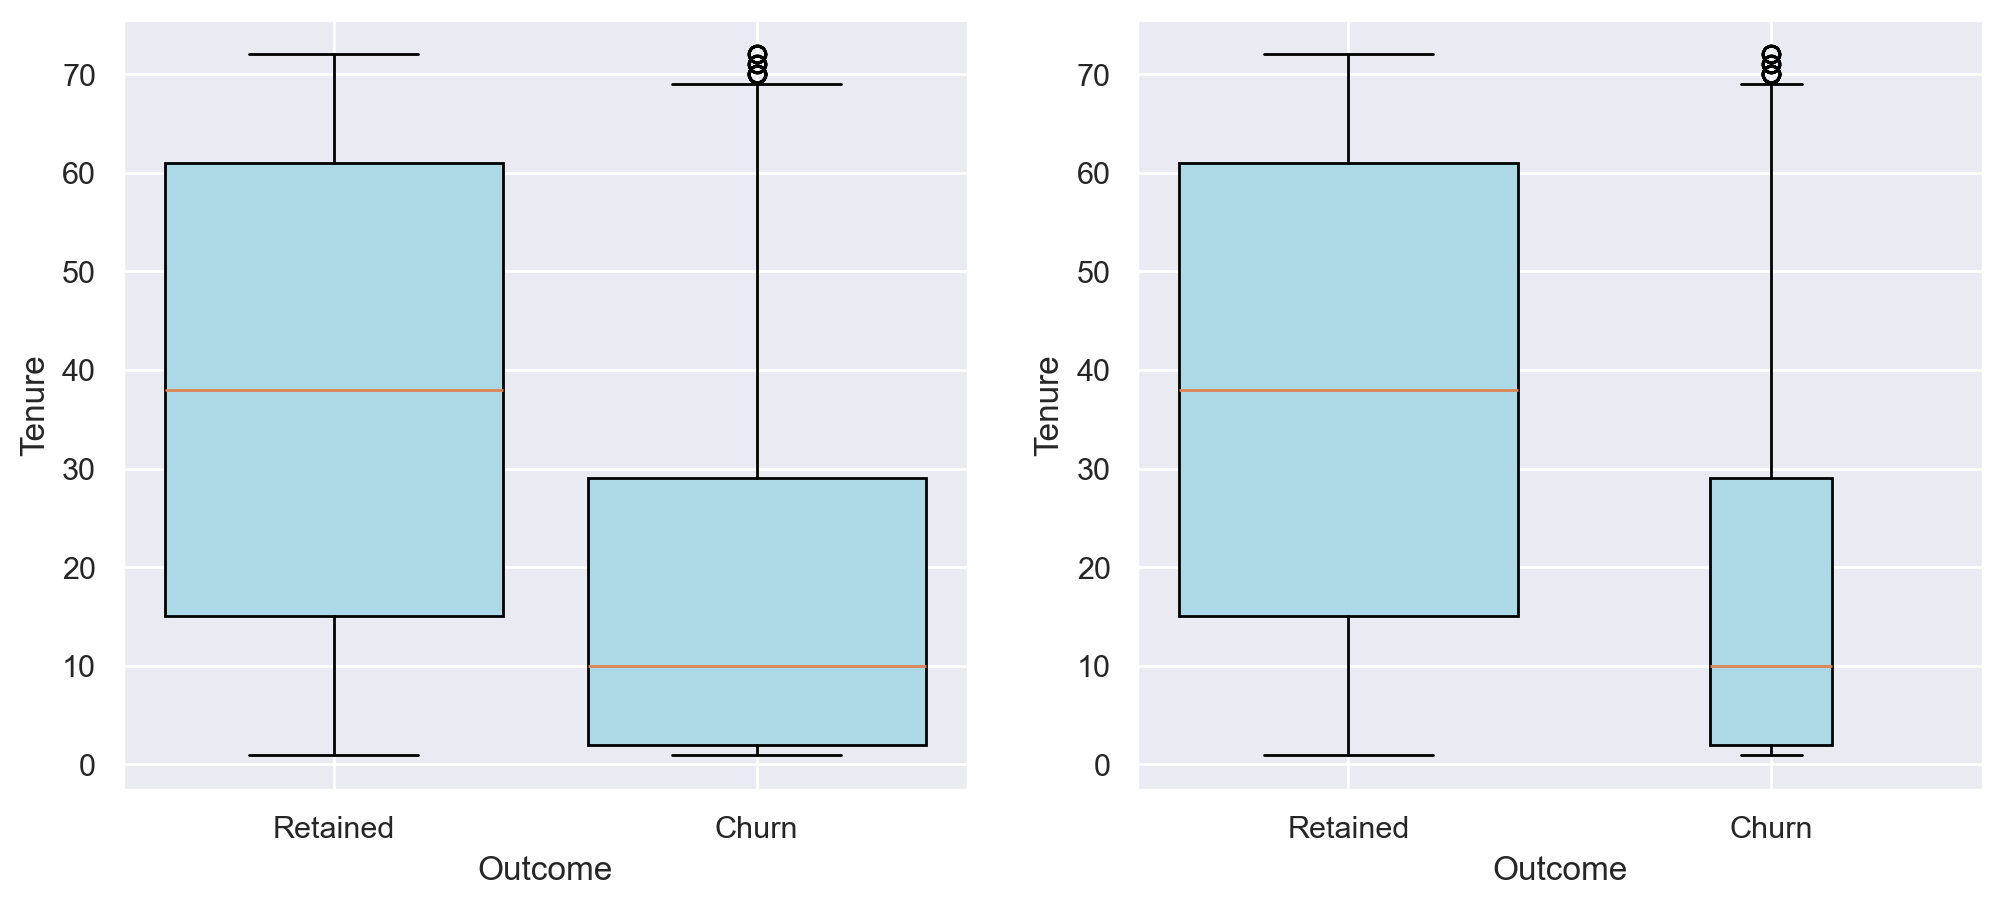

In [17]:
# One complaint about boxplots is that the number of observations in 
# each category is lost in the traditional display of the 
# boxes. The code below illustrates how to create variable width 
# boxplots based on the number of observations.
# source of concept:
# https://stackoverflow.com/questions/63792528/boxplot-custom-width-in-seaborn

sns.set()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

bins, groups = zip(*mydata.groupby('leave')['tenure'])
lengths = np.array([len(group) for group in groups])
max_width = 0.8


ax1.boxplot(groups, widths = max_width, 
           patch_artist=True, boxprops={'facecolor': 'lightblue'})
ax1.set(xlabel='Outcome', ylabel='Tenure')
ax1.set_xticklabels(['Retained','Churn'])

ax2.boxplot(groups, widths=max_width * lengths / lengths.max(),
          patch_artist=True, boxprops={'facecolor': 'lightblue'})
ax2.set_xticklabels(['Retained','Churn'])
ax2.set(xlabel='Outcome', ylabel='Tenure')
plt.show

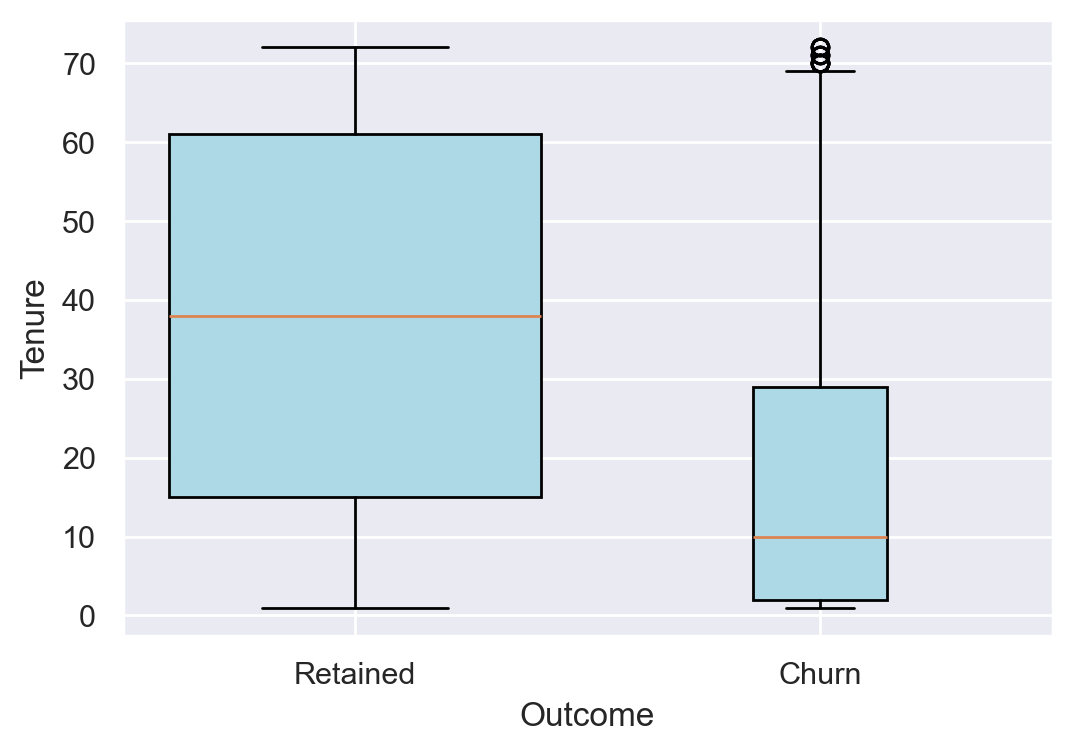

In [18]:
# Perform this seaborn.reset_defaults()sns.set()
sns.reset_defaults()
sns.set()
fig, (ax1) = plt.subplots(ncols=1, figsize=(6, 4))
lengths = np.array([len(group) for group in groups])
max_width = 0.8

bins, groups = zip(*mydata.groupby('leave')['tenure'])

ax1.boxplot(groups, widths=max_width * lengths / lengths.max(),
          patch_artist=True, boxprops={'facecolor': 'lightblue'})
ax1.set_xticklabels(['Retained','Churn'])
ax1.set(xlabel='Outcome', ylabel='Tenure')
plt.show()

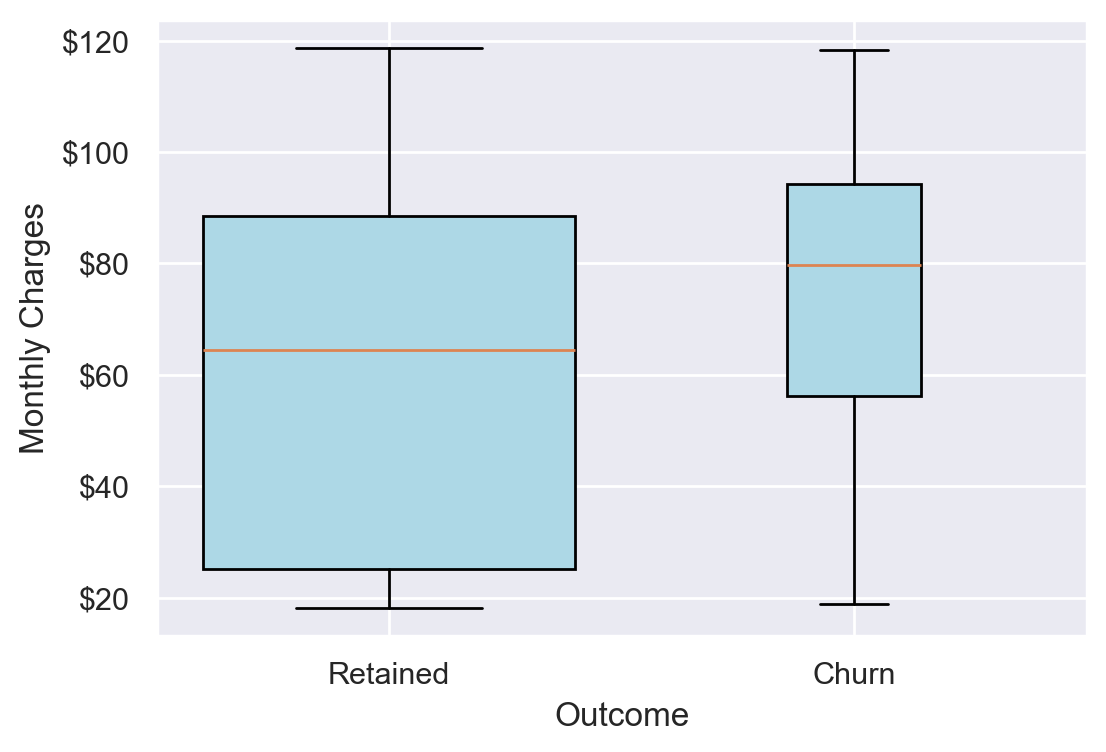

In [19]:
sns.set()
fig, (ax1) = plt.subplots(ncols=1, figsize=(6, 4))
lengths = np.array([len(group) for group in groups])
max_width = 0.8

bins, groups = zip(*mydata.groupby('leave')['MonthlyCharges'])

ax1.boxplot(groups, widths=max_width * lengths / lengths.max(),
          patch_artist=True, boxprops={'facecolor': 'lightblue'})
ax1.set_xticklabels(['Retained','Churn'])
ax1.set(xlabel='Outcome', ylabel='Monthly Charges')
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}')) # include the $ and commas in thousands
plt.show()

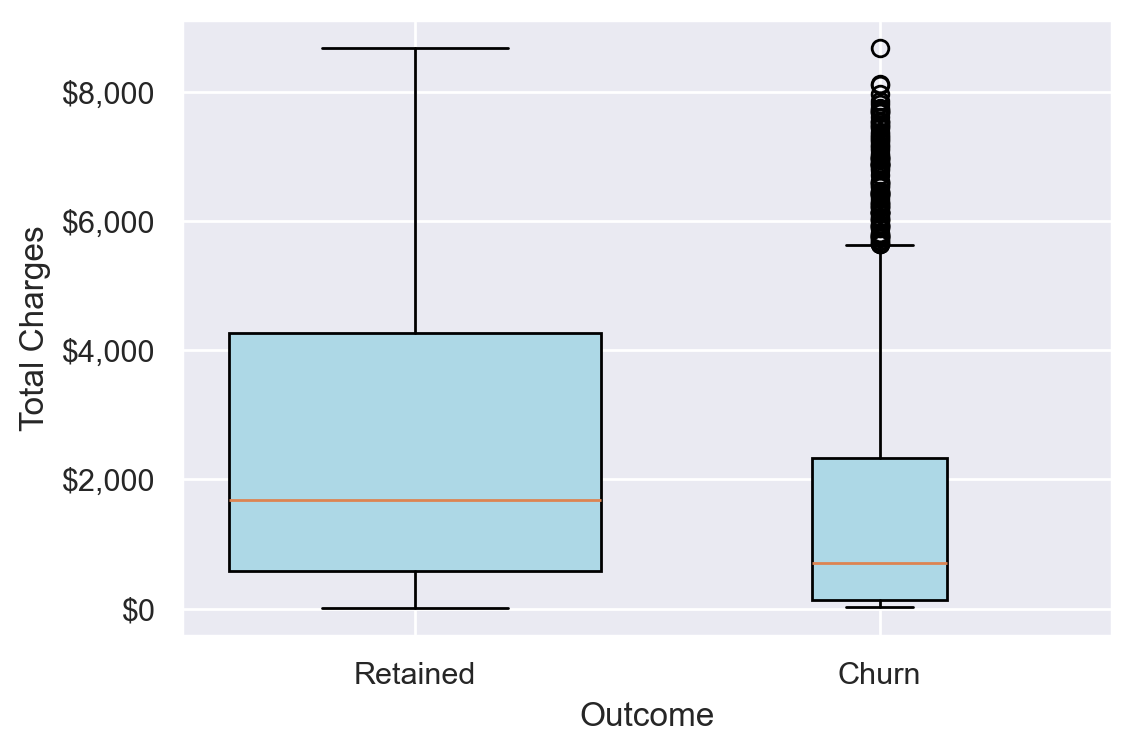

In [20]:
sns.set()
fig, (ax1) = plt.subplots(ncols=1, figsize=(6, 4))
lengths = np.array([len(group) for group in groups])
max_width = 0.8

bins, groups = zip(*mydata.groupby('leave')['TotalCharges'])

ax1.boxplot(groups, widths=max_width * lengths / lengths.max(),
          patch_artist=True, boxprops={'facecolor': 'lightblue'})
ax1.set_xticklabels(['Retained','Churn'])
ax1.set(xlabel='Outcome', ylabel='Total Charges')
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}')) # include the $ and commas in thousands
plt.show()

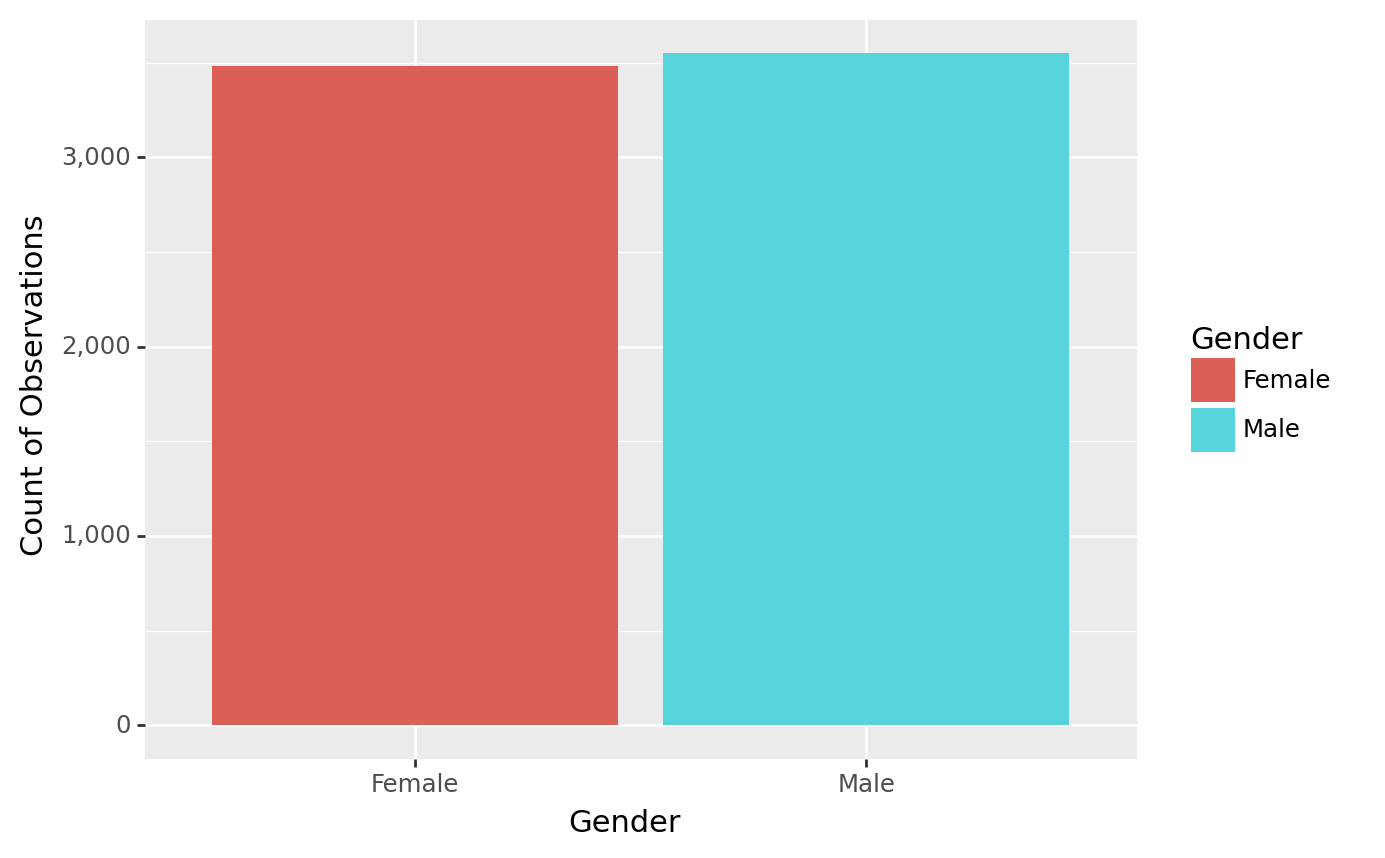

<ggplot: (333041917)>

In [21]:
(
ggplot(mydata, aes('gender', fill='gender'))+
    geom_bar()+
    scale_y_continuous(labels=mizani.formatters.comma_format(digits=0))+
    labs(x="Gender", y="Count of Observations", fill="Gender")
)

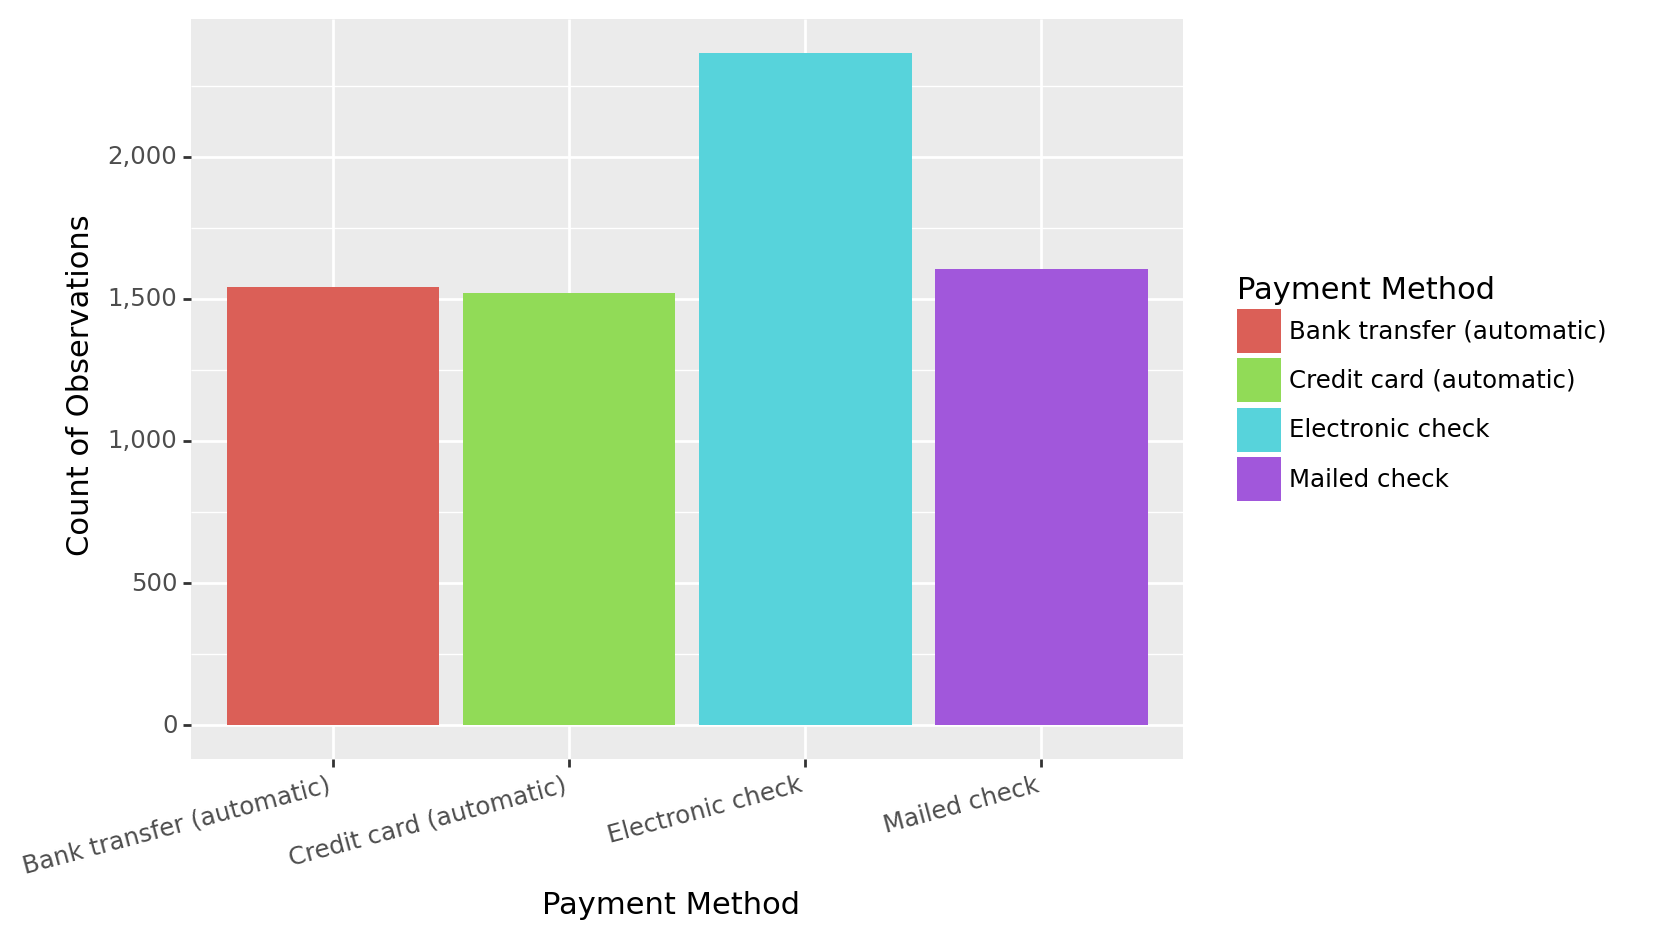

<ggplot: (333228913)>

In [22]:
(
ggplot(mydata, aes('PaymentMethod', fill='PaymentMethod'))+
    geom_bar()+
    scale_y_continuous(labels=mizani.formatters.comma_format(digits=0))+
    labs(x="Payment Method", y="Count of Observations", fill="Payment Method")+
    theme(axis_text_x=element_text(rotation=15, hjust=1))
)

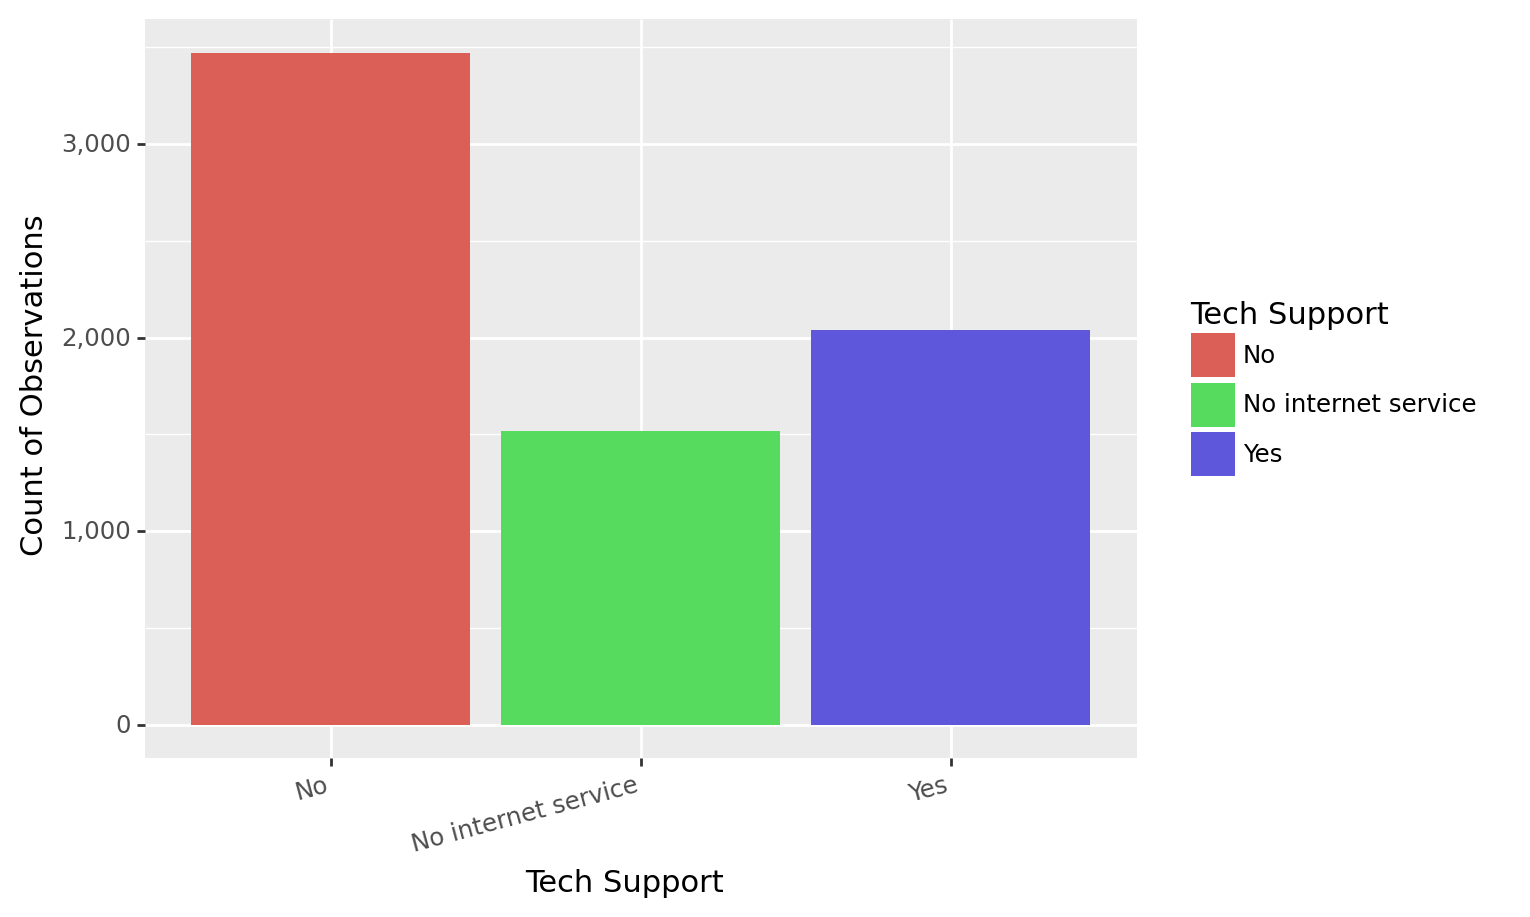

<ggplot: (333248889)>

In [23]:
(
ggplot(mydata, aes('TechSupport', fill='TechSupport'))+
    geom_bar()+
    scale_y_continuous(labels=mizani.formatters.comma_format(digits=0))+
    labs(x="Tech Support", y="Count of Observations", fill="Tech Support")+
    theme(axis_text_x=element_text(rotation=15, hjust=1))
)

In [24]:
# restore the df
dropCols = ['customerID','leave']
model_df = mydata.drop(dropCols, axis = 1)
model_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,NotSC,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,NotSC,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,NotSC,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,NotSC,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,NotSC,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [25]:
for col in list(model_df.columns):
    print(col, model_df[col].nunique())

gender 2
SeniorCitizen 2
Partner 2
Dependents 2
tenure 72
PhoneService 2
MultipleLines 3
InternetService 3
OnlineSecurity 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
StreamingMovies 3
Contract 3
PaperlessBilling 2
PaymentMethod 4
MonthlyCharges 1584
TotalCharges 6530
Churn 2


In [26]:
# set up some important features of the dataset
# identifies features by type (categorical or numerical)
SEED = 365
TARGET = 'Churn'
FEATURES = model_df.columns.drop(TARGET)

NUMERICAL = model_df[FEATURES].select_dtypes('number').columns
print(f"Numerical features: {', '.join(NUMERICAL)}")

CATEGORICAL = pd.Index(np.setdiff1d(FEATURES, NUMERICAL))
print(f"Categorical features: {', '.join(CATEGORICAL)}")

Numerical features: tenure, MonthlyCharges, TotalCharges
Categorical features: Contract, Dependents, DeviceProtection, InternetService, MultipleLines, OnlineBackup, OnlineSecurity, PaperlessBilling, Partner, PaymentMethod, PhoneService, SeniorCitizen, StreamingMovies, StreamingTV, TechSupport, gender


In [27]:
# set up the data for prediction
# it will first separate the data into train / test
# then it will use the train data to transform categorical data and fill in missing data
X_train, X_test, y_train, y_test = train_test_split(model_df.drop(columns=TARGET), model_df[TARGET], 
                                                    test_size=.2, random_state=SEED, 
                                                    stratify=model_df[TARGET])
num_imputer = SimpleImputer(strategy='mean')
train_num_imputed = num_imputer.fit_transform(X_train[NUMERICAL])

scaler = MinMaxScaler()
train_num_scaled = scaler.fit_transform(train_num_imputed)

cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
train_cat_imputed = cat_imputer.fit_transform(X_train[CATEGORICAL])

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
train_cat_encoded = encoder.fit_transform(train_cat_imputed)

train_preprocessed = np.concatenate((train_num_scaled, train_cat_encoded), axis=1)

columns = np.append(NUMERICAL, encoder.get_feature_names_out(CATEGORICAL))
pd.DataFrame(train_preprocessed, columns=columns, index=X_train.index).head()

,tenure,MonthlyCharges,TotalCharges,Contract_One year,Contract_Two year,Dependents_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,InternetService_Fiber optic,InternetService_No,...,PaymentMethod_Mailed check,PhoneService_Yes,SeniorCitizen_Senior,StreamingMovies_No internet service,StreamingMovies_Yes,StreamingTV_No internet service,StreamingTV_Yes,TechSupport_No internet service,TechSupport_Yes,gender_Male
848,1.000000,0.733831,0.780447,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
4866,0.211268,0.445771,0.120961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3019,0.295775,0.367164,0.137001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2923,0.746479,0.711940,0.536372,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
380,0.563380,0.676119,0.383135,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
model = LogisticRegression()
model.fit(train_preprocessed, y_train)

LogisticRegression()

In [29]:
def calculate_roc_auc(model_pipe, X, y):
    """Calculate roc auc score. 
    
    Parameters:
    ===========
    model_pipe: sklearn model or pipeline
    X: features
    y: true target
    """
    y_proba = model_pipe.predict_proba(X)[:,1]
    return roc_auc_score(y, y_proba)

In [30]:
test_num_imputed = num_imputer.transform(X_test[NUMERICAL])
test_num_scaled = scaler.transform(test_num_imputed)
test_cat_imputed = cat_imputer.transform(X_test[CATEGORICAL])
test_cat_encoded = encoder.transform(test_cat_imputed)
test_preprocessed = np.concatenate((test_num_scaled, test_cat_encoded), axis=1)

print(f"Train ROC-AUC: {calculate_roc_auc(model, train_preprocessed, y_train):.4f}")
print(f"Test ROC-AUC: {calculate_roc_auc(model, test_preprocessed, y_test):.4f}")

Train ROC-AUC: 0.8474
Test ROC-AUC: 0.8462


In [31]:
# this code uses the same data, but...
# it sets up a pipeline approach that is repeatable
# imputer is used to substitute the mean for missing numeric values
# then it scales using the MinMaxScaler method
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, NUMERICAL),
    ('cat', categorical_pipe, CATEGORICAL)
])

pipe = Pipeline([
    ('preprocessors', preprocessors),
    ('model', LogisticRegression())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['Contract', 'Dependents', 'DeviceProtection', 'InternetService',
       'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling',
       'Partner', 'PaymentMethod', 'PhoneService', 'SeniorCitizen',
       'StreamingMovies', 'StreamingTV', 'TechSupport', 'gender'],
      dtype='object'))])),
                ('model', LogisticRegression())])

In [32]:
# The results are the same as the longer approach to preprocessing and training above.
print(f"Train ROC-AUC: {calculate_roc_auc(pipe, X_train, y_train):.4f}")
print(f"Test ROC-AUC: {calculate_roc_auc(pipe, X_test, y_test):.4f}")

Train ROC-AUC: 0.8474
Test ROC-AUC: 0.8462


In [33]:
# Now analyze the model predictions
# https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
# examine the probabilities resulting from the model
probs = pipe.predict_proba(X_test)
probs = probs[:, 1]
probs

array([0.27997473, 0.00396479, 0.58885032, ..., 0.13796469, 0.03096054,
       0.388727  ])

In [34]:
# set up a multiple model pipelines
# https://ryan-reilly.medium.com/gridsearch-pipelines-of-multiple-models-on-multiclass-classification-e9124b6ea2e3
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('LR', LogisticRegression(random_state=365))])
pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('DT',DecisionTreeClassifier(random_state=365))])
pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('RF',RandomForestClassifier(random_state=365))])
pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('scl', StandardScaler()),
                     ('SVM', svm.SVC(random_state=365))])
pipe_xgb = Pipeline([('scl', StandardScaler()),
                     ('XGB', XGBClassifier(random_state=365))])

In [35]:
# set up the hyperparameters for the models
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]
lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': param_range_fl,
                   'LR__solver': ['liblinear']}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]
rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]
knn_param_grid = [{'KNN__n_neighbors': param_range,
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]
svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': param_range}]
xgb_param_grid = [{'XGB__learning_rate': learning_rates,
                    'XGB__max_depth': param_range,
                    'XGB__min_child_weight': param_range[:2],
                    'XGB__subsample': param_range_fl,
                    'XGB__n_estimators': n_estimators}]

In [36]:
# set up the grid search for each of the models
lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid,
        scoring='accuracy',
        cv=3)
dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='accuracy',
        cv=3)
rf_grid_search = GridSearchCV(estimator=pipe_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=3)
knn_grid_search = GridSearchCV(estimator=pipe_knn,
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=3)
svm_grid_search = GridSearchCV(estimator=pipe_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=3)
xgb_grid_search = GridSearchCV(estimator=pipe_xgb,
        param_grid=xgb_param_grid,
        scoring='accuracy',
        cv=3)

In [37]:
X_train = train_preprocessed
X_test = test_preprocessed

In [38]:
# run the pipelines
grids = [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search, svm_grid_search, xgb_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

In [39]:
# assess the different model types using accuracy and provide the hyperparameters used
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines', 5: 'XGBoost'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],
    model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(grid_dict[i],          model.best_params_))

Logistic Regression Test Accuracy: 0.8187633262260128
Logistic Regression Best Params: {'LR__C': 0.1, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
Decision Trees Test Accuracy: 0.7889125799573561
Decision Trees Best Params: {'DT__criterion': 'gini', 'DT__max_depth': 2, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 2}
Random Forest Test Accuracy: 0.798862828713575
Random Forest Best Params: {'RF__max_depth': 6, 'RF__min_samples_leaf': 6, 'RF__min_samples_split': 2}
K-Nearest Neighbors Test Accuracy: 0.7647476901208244
K-Nearest Neighbors Best Params: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 6, 'KNN__weights': 'uniform'}
Support Vector Machines Test Accuracy: 0.814498933901919
Support Vector Machines Best Params: {'SVM__C': 1, 'SVM__kernel': 'rbf'}
XGBoost Test Accuracy: 0.8081023454157783
XGBoost Best Params: {'XGB__learning_rate': 0.2, 'XGB__max_depth': 3, 'XGB__min_child_weight': 2, 'XGB__n_estimators': 50, 'XGB__subsample': 1.0}


In [40]:
sklearn.__version__

'1.3.0'

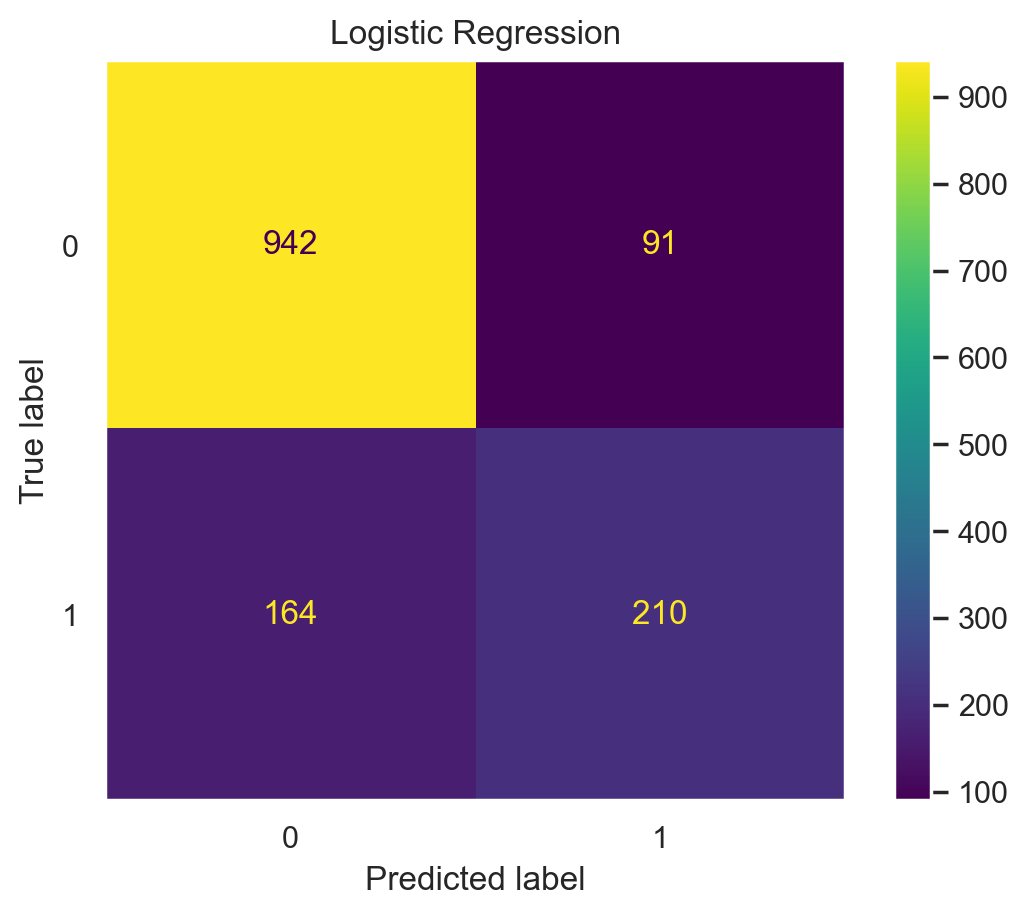

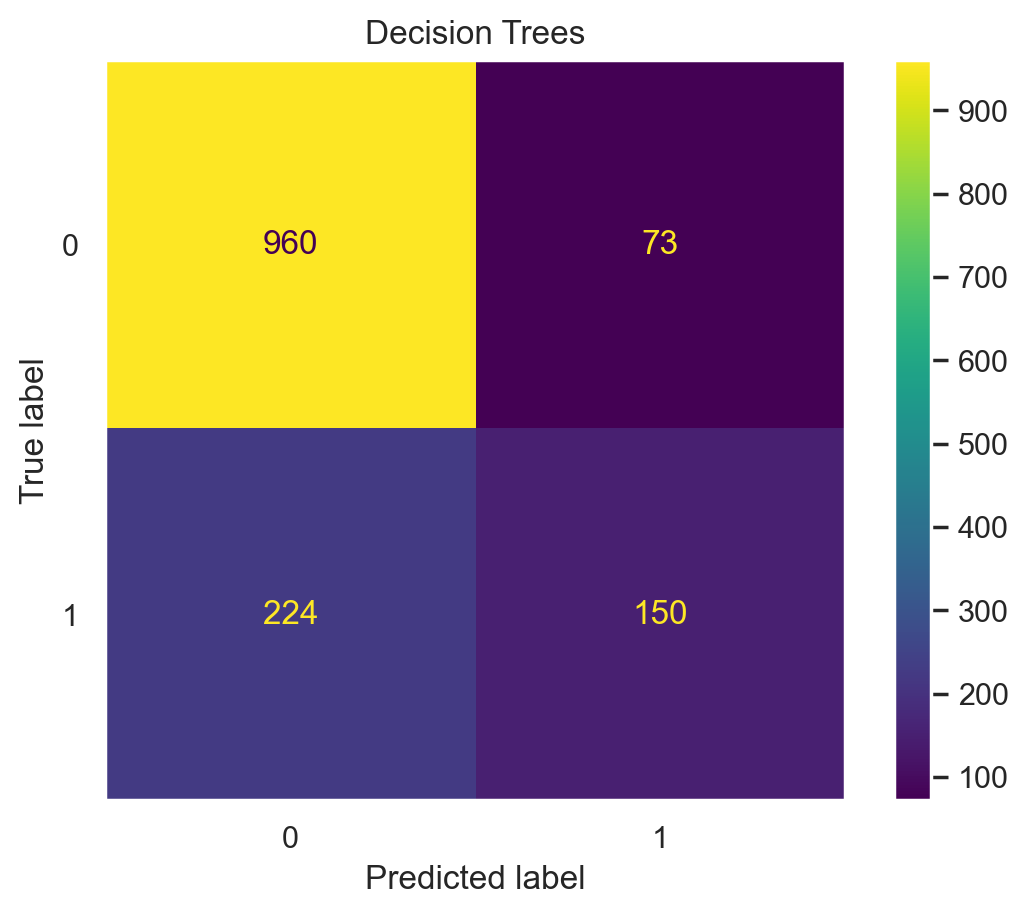

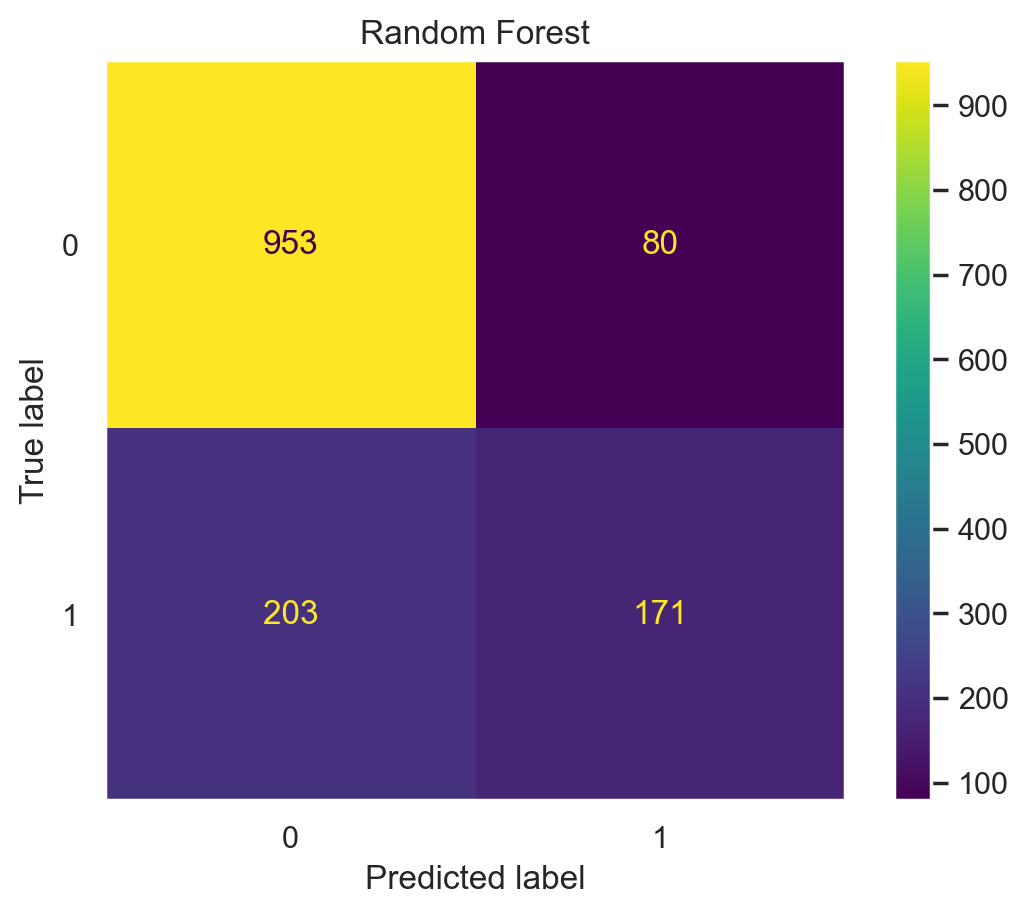

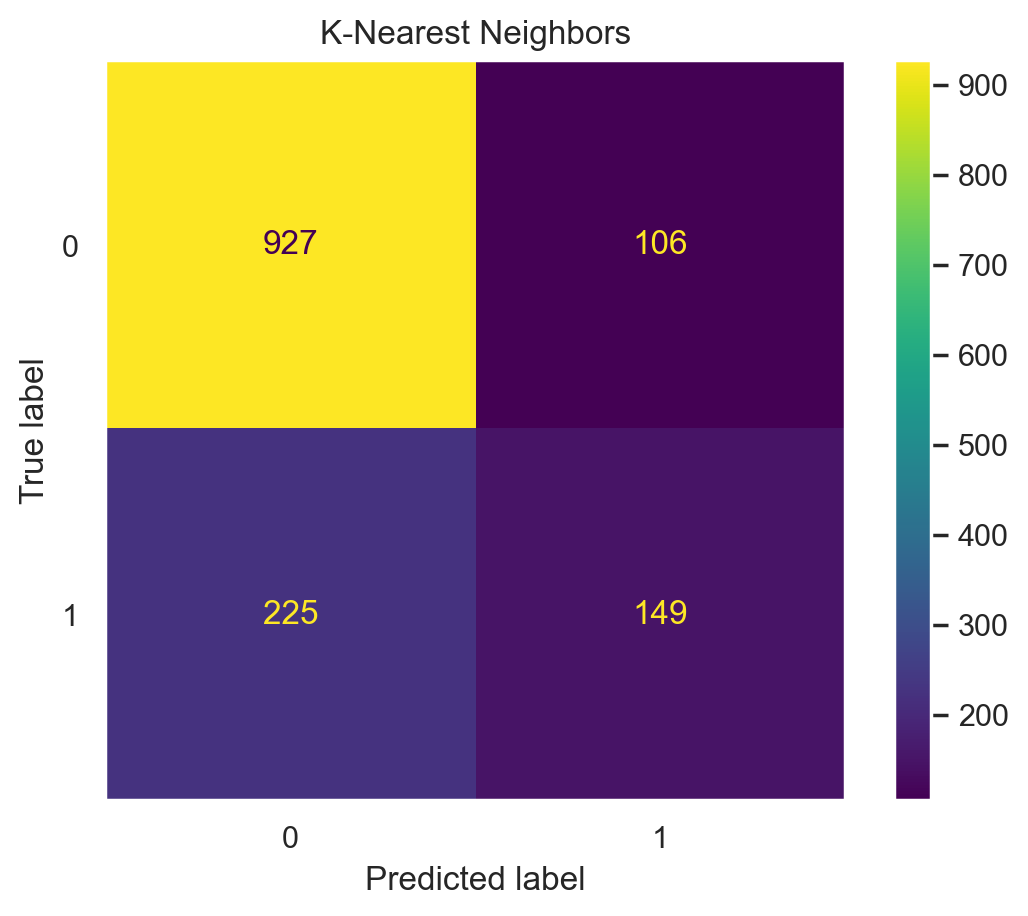

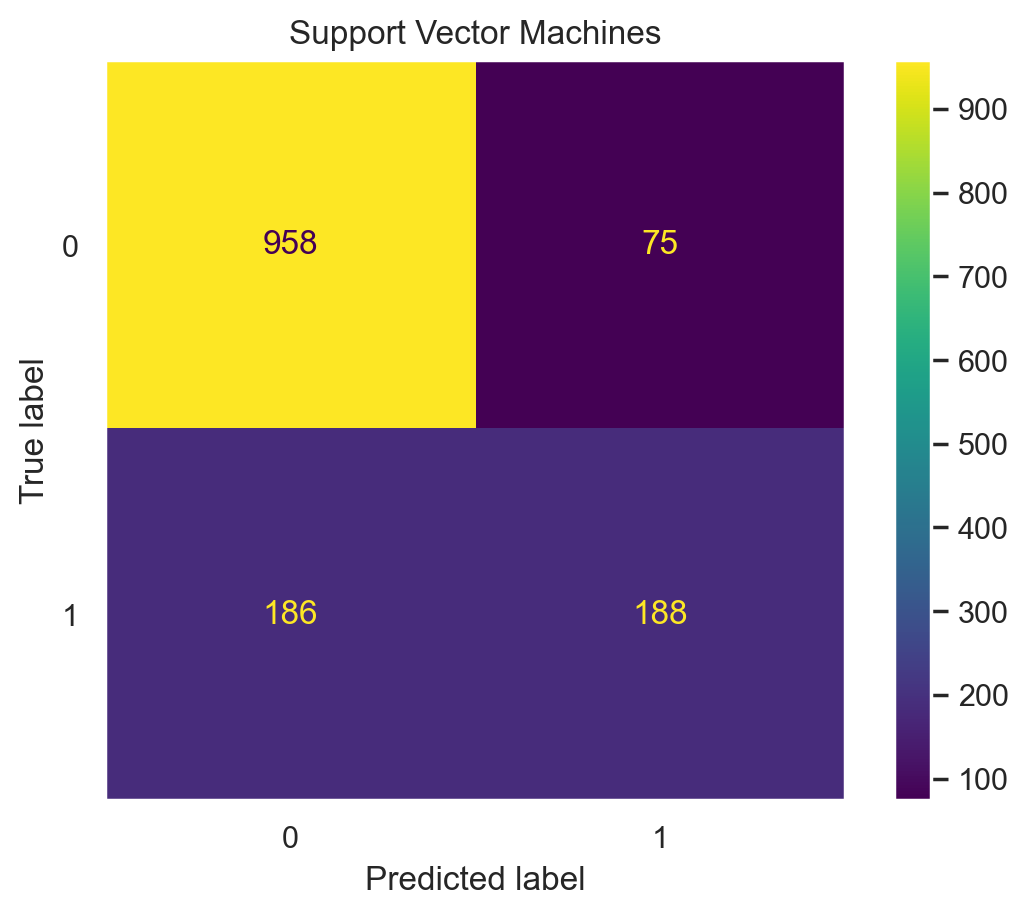

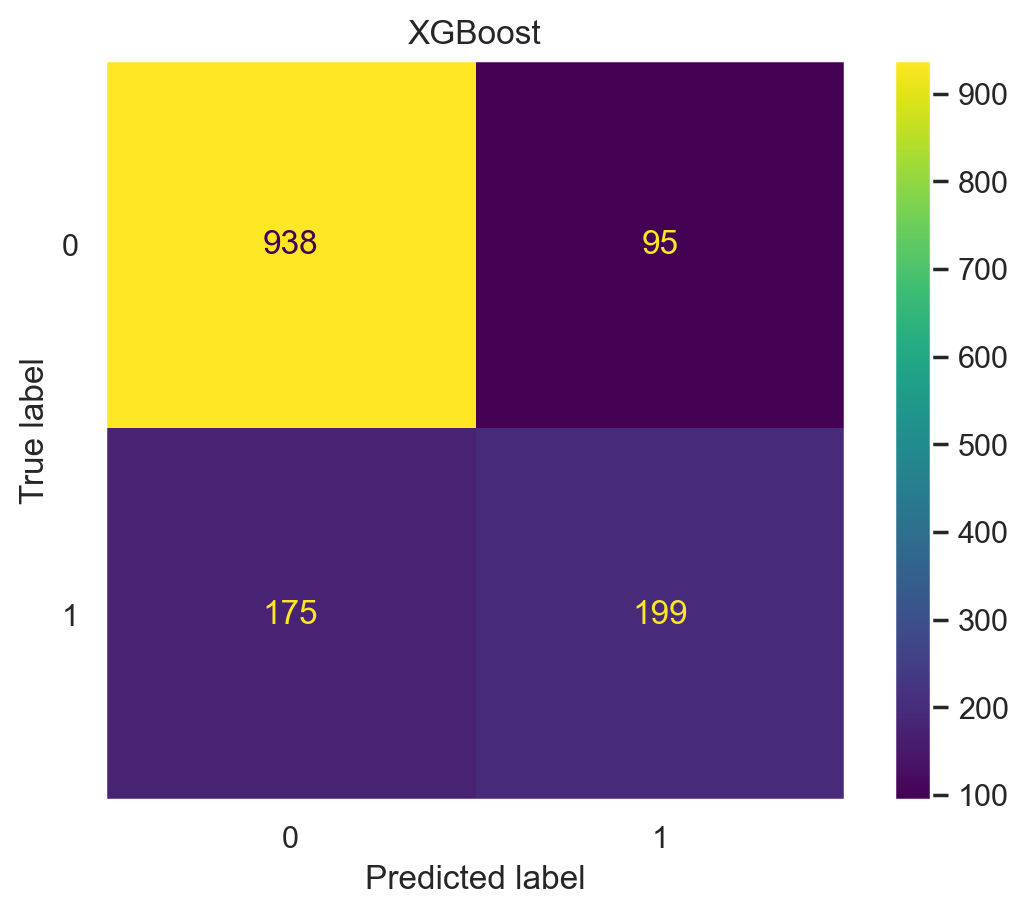

In [41]:
for i, model in enumerate (grids):
    model.predict(X_test)
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
    disp.plot()
    plt.grid(None)
    plt.title(grid_dict[i])
    pyplot.show()

In [42]:
# extract the probabilities from each model and save in lists
lr_pred = lr_grid_search.predict_proba(X_test)[:, 1]
dt_pred = dt_grid_search.predict_proba(X_test)[:, 1]
rf_pred = rf_grid_search.predict_proba(X_test)[:, 1]
knn_pred = knn_grid_search.predict_proba(X_test)[:, 1]
# svm_pred = svm_grid_search.predict_proba(X_test)[:, 1] received an error that can't predict when proability is false
# https://stackoverflow.com/questions/43036711/scikit-learn-svc-predict-probability-doesnt-work-as-expected
xgb_pred = xgb_grid_search.predict_proba(X_test)[:, 1]

In [43]:
# method found here
# https://www.imranabdullah.com/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot
# Instantiate the classfiers and make a list
classifiers = [lr_grid_search, 
               dt_grid_search, 
               rf_grid_search,
               knn_grid_search,
               xgb_grid_search]

classifier_names = ["Logistic Regression",
                   "Decision Tree",
                   "Random Forest",
                   "K Nearest Neighbors",
                   "Extreme Gradient Boosting Machine"]

result_table = pd.DataFrame(columns=['classifiers', 'classifierNames', 'fpr','tpr','auc'])
# result_table
# Apply the models and record the results
for cls in classifiers:
    model = cls
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table._append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
result_table['classifierNames'] = np.array(classifier_names)
result_table.reset_index(inplace=True)
result_table['classifers'] = np.array(classifiers)
result_table

,classifiers,classifierNames,fpr,tpr,auc,classifers
0,GridSearchCV,Logistic Regression,"[0.0, 0.0, 0.0, 0.000968054211035818, 0.000968...","[0.0, 0.00267379679144385, 0.02673796791443850...",0.845465,"GridSearchCV(cv=3,\n estimator=Pip..."
1,GridSearchCV,Decision Tree,"[0.0, 0.07066795740561471, 0.29235237173281703...","[0.0, 0.40106951871657753, 0.606951871657754, ...",0.755874,"GridSearchCV(cv=3,\n estimator=Pip..."
2,GridSearchCV,Random Forest,"[0.0, 0.0, 0.0, 0.000968054211035818, 0.000968...","[0.0, 0.00267379679144385, 0.01336898395721925...",0.847111,"GridSearchCV(cv=3,\n estimator=Pip..."
3,GridSearchCV,K Nearest Neighbors,"[0.0, 0.008712487899322363, 0.0387221684414327...","[0.0, 0.05614973262032086, 0.18181818181818182...",0.776183,"GridSearchCV(cv=3,\n estimator=Pip..."
4,GridSearchCV,Extreme Gradient Boosting Machine,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00290416...","[0.0, 0.00267379679144385, 0.0053475935828877,...",0.851066,"GridSearchCV(cv=3,\n estimator=Pip..."


In [44]:
classifiers = [lr_grid_search, 
               dt_grid_search, 
               rf_grid_search,
               knn_grid_search,
               xgb_grid_search]
result_table['classifiers'] = np.array(classifiers)
result_table

,classifiers,classifierNames,fpr,tpr,auc,classifers
0,"GridSearchCV(cv=3,\n estimator=Pip...",Logistic Regression,"[0.0, 0.0, 0.0, 0.000968054211035818, 0.000968...","[0.0, 0.00267379679144385, 0.02673796791443850...",0.845465,"GridSearchCV(cv=3,\n estimator=Pip..."
1,"GridSearchCV(cv=3,\n estimator=Pip...",Decision Tree,"[0.0, 0.07066795740561471, 0.29235237173281703...","[0.0, 0.40106951871657753, 0.606951871657754, ...",0.755874,"GridSearchCV(cv=3,\n estimator=Pip..."
2,"GridSearchCV(cv=3,\n estimator=Pip...",Random Forest,"[0.0, 0.0, 0.0, 0.000968054211035818, 0.000968...","[0.0, 0.00267379679144385, 0.01336898395721925...",0.847111,"GridSearchCV(cv=3,\n estimator=Pip..."
3,"GridSearchCV(cv=3,\n estimator=Pip...",K Nearest Neighbors,"[0.0, 0.008712487899322363, 0.0387221684414327...","[0.0, 0.05614973262032086, 0.18181818181818182...",0.776183,"GridSearchCV(cv=3,\n estimator=Pip..."
4,"GridSearchCV(cv=3,\n estimator=Pip...",Extreme Gradient Boosting Machine,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00290416...","[0.0, 0.00267379679144385, 0.0053475935828877,...",0.851066,"GridSearchCV(cv=3,\n estimator=Pip..."


In [45]:
for i in result_table.index:
    print(result_table.loc[i]['auc'])

0.8454646401374949
0.7558743289624219
0.8471108499723043
0.7761827603522269
0.8510658949842368


In [46]:
result_table.set_index('classifierNames', drop=False)

,classifiers,classifierNames,fpr,tpr,auc,classifers
classifierNames,,,,,,
Logistic Regression,"GridSearchCV(cv=3,\n estimator=Pip...",Logistic Regression,"[0.0, 0.0, 0.0, 0.000968054211035818, 0.000968...","[0.0, 0.00267379679144385, 0.02673796791443850...",0.845465,"GridSearchCV(cv=3,\n estimator=Pip..."
Decision Tree,"GridSearchCV(cv=3,\n estimator=Pip...",Decision Tree,"[0.0, 0.07066795740561471, 0.29235237173281703...","[0.0, 0.40106951871657753, 0.606951871657754, ...",0.755874,"GridSearchCV(cv=3,\n estimator=Pip..."
Random Forest,"GridSearchCV(cv=3,\n estimator=Pip...",Random Forest,"[0.0, 0.0, 0.0, 0.000968054211035818, 0.000968...","[0.0, 0.00267379679144385, 0.01336898395721925...",0.847111,"GridSearchCV(cv=3,\n estimator=Pip..."
K Nearest Neighbors,"GridSearchCV(cv=3,\n estimator=Pip...",K Nearest Neighbors,"[0.0, 0.008712487899322363, 0.0387221684414327...","[0.0, 0.05614973262032086, 0.18181818181818182...",0.776183,"GridSearchCV(cv=3,\n estimator=Pip..."
Extreme Gradient Boosting Machine,"GridSearchCV(cv=3,\n estimator=Pip...",Extreme Gradient Boosting Machine,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00290416...","[0.0, 0.00267379679144385, 0.0053475935828877,...",0.851066,"GridSearchCV(cv=3,\n estimator=Pip..."


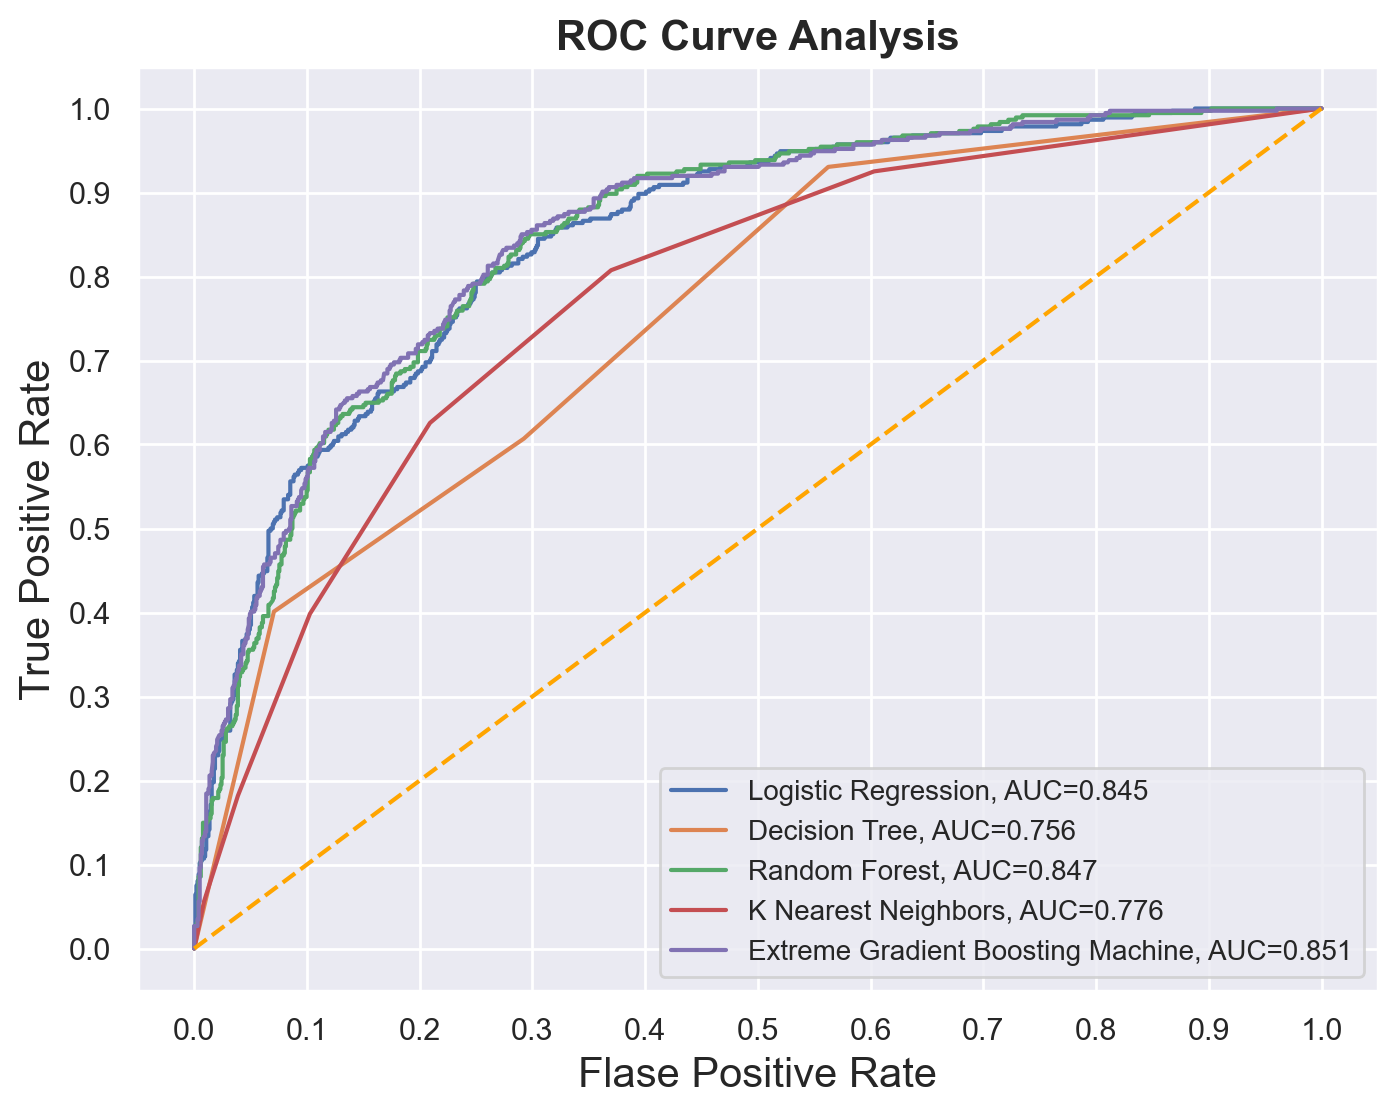

In [47]:
# plot the ROC curves for each of the model types
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(result_table.loc[i]['classifierNames'],result_table.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':10}, loc='lower right')

plt.show()

# Identifying your best customers

How would we identify our best customers. Utilize the Test subset data frame and discuss which features will help us identify the best customers.

In [48]:
# this section of code will set up the data for prediction correctly
# it will first separate the data into train / test
# then it will use the train data to transform categorical data and fill in missing data
X_train, X_test, y_train, y_test = train_test_split(model_df.drop(columns=TARGET), model_df[TARGET], 
                                                    test_size=.2, random_state=SEED, 
                                                    stratify=model_df[TARGET])
num_imputer = SimpleImputer(strategy='mean')
test_num_imputed = num_imputer.fit_transform(X_test[NUMERICAL])

scaler = MinMaxScaler()
test_num_scaled = scaler.fit_transform(test_num_imputed)

cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
test_cat_imputed = cat_imputer.fit_transform(X_test[CATEGORICAL])

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
test_cat_encoded = encoder.fit_transform(test_cat_imputed)

test_preprocessed = np.concatenate((test_num_scaled, test_cat_encoded), axis=1)

columns = np.append(NUMERICAL, encoder.get_feature_names_out(CATEGORICAL))
pd.DataFrame(test_preprocessed, columns=columns, index=X_test.index).info()

<class 'pandas.core.frame.DataFrame'>
Index: 1407 entries, 2754 to 744
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 1407 non-null   float64
 1   MonthlyCharges                         1407 non-null   float64
 2   TotalCharges                           1407 non-null   float64
 3   Contract_One year                      1407 non-null   float64
 4   Contract_Two year                      1407 non-null   float64
 5   Dependents_Yes                         1407 non-null   float64
 6   DeviceProtection_No internet service   1407 non-null   float64
 7   DeviceProtection_Yes                   1407 non-null   float64
 8   InternetService_Fiber optic            1407 non-null   float64
 9   InternetService_No                     1407 non-null   float64
 10  MultipleLines_No phone service         1407 non-null   float64
 11  Multipl

In [49]:
X_train, X_test, y_train, y_test = train_test_split(model_df.drop(columns=TARGET), model_df[TARGET], 
                                                    test_size=.2, random_state=SEED, 
                                                    stratify=model_df[TARGET])


Xtest = pd.DataFrame(X_test)
ytest = pd.DataFrame(y_test)


clvAnalysis = pd.concat([Xtest, ytest], axis = 1)
clvAnalysis

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2754,Male,NotSC,No,No,3,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,41.35,107.25,0
316,Male,NotSC,No,No,71,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),19.90,1355.10,0
2288,Female,NotSC,No,No,5,Yes,No,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Mailed check,85.30,420.45,0
1632,Male,NotSC,No,No,48,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),106.10,5082.80,1
145,Female,NotSC,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,No,Two year,Yes,Credit card (automatic),99.05,6416.70,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5443,Male,NotSC,No,No,26,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45.45,1233.15,0
243,Female,Senior,Yes,No,65,Yes,No,Fiber optic,Yes,Yes,Yes,No,No,Yes,Month-to-month,No,Electronic check,94.40,6126.15,0
653,Female,NotSC,No,No,17,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,24.80,475.25,0
1814,Male,NotSC,Yes,Yes,12,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.70,258.35,0


In [50]:
# predict the test probabilities using the Random Forest Grid Search Model
yProbs = rf_grid_search.predict_proba(test_preprocessed)[::,1]
yProbs

array([0.38216207, 0.01960635, 0.57596841, ..., 0.08417563, 0.05496471,
       0.4227018 ])

In [51]:
yPreds = rf_grid_search.predict(test_preprocessed)
yPreds

array([0, 0, 1, ..., 0, 0, 0])

In [52]:
# add the calculated probabilities to the clv analysis data frame
clvAnalysis['yProbs'] = yProbs
clvAnalysis['yPreds'] = yPreds
clvAnalysis

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,yProbs,yPreds
2754,Male,NotSC,No,No,3,No,No phone service,DSL,Yes,No,...,No,No,Month-to-month,No,Mailed check,41.35,107.25,0,0.382162,0
316,Male,NotSC,No,No,71,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Two year,Yes,Credit card (automatic),19.90,1355.10,0,0.019606,0
2288,Female,NotSC,No,No,5,Yes,No,Fiber optic,No,Yes,...,Yes,No,Month-to-month,Yes,Mailed check,85.30,420.45,0,0.575968,1
1632,Male,NotSC,No,No,48,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,One year,Yes,Credit card (automatic),106.10,5082.80,1,0.260364,0
145,Female,NotSC,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,Yes,...,Yes,No,Two year,Yes,Credit card (automatic),99.05,6416.70,0,0.081130,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5443,Male,NotSC,No,No,26,Yes,No,DSL,No,No,...,No,No,Month-to-month,No,Electronic check,45.45,1233.15,0,0.255766,0
243,Female,Senior,Yes,No,65,Yes,No,Fiber optic,Yes,Yes,...,No,Yes,Month-to-month,No,Electronic check,94.40,6126.15,0,0.243158,0
653,Female,NotSC,No,No,17,Yes,Yes,No,No internet service,No internet service,...,No internet service,No internet service,Month-to-month,No,Mailed check,24.80,475.25,0,0.084176,0
1814,Male,NotSC,Yes,Yes,12,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,19.70,258.35,0,0.054965,0


In [53]:
# identify the churn label as truth
y_truth = clvAnalysis['Churn']

In [54]:
print(classification_report(yPreds, y_truth))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1156
           1       0.46      0.68      0.55       251

    accuracy                           0.80      1407
   macro avg       0.69      0.75      0.71      1407
weighted avg       0.84      0.80      0.81      1407



In [55]:
# show the confustion matrix
cm = metrics.confusion_matrix(y_truth, yPreds)
cm

array([[953,  80],
       [203, 171]])

In [56]:
to_excel = pd.DataFrame(clvAnalysis)
to_excel.to_excel("clvAnalysis.xlsx")